In [1]:
import os
import random
import re
import sys
from datetime import datetime
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn import preprocessing
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [2]:
path = "/Users/M283455/VAE_prject/scripts/"
sys.path.insert(0, path)

In [3]:
import VAE_tybalt
from VAE_tybalt import VAE

In [4]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [5]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

## Load data

In [6]:
tcga_tybalt_file_location = "../../VAE_prject_data/raw/rnaseq_df_test.csv"
rnaseq_df = pd.read_csv(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1, inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [7]:
rnaseq_df.head(5)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.000000,0.676411,0.538535,0.829060,0.371617,0.076709,0.493035,0.495491,0.000000,0.000000,...,0.641401,0.258891,0.520563,0.400908,0.437579,0.560402,0.483713,0.054940,0.333915,0.313550
1,0.000000,0.601335,0.791538,0.580519,0.711329,0.771928,0.557838,0.656916,0.000000,0.000000,...,0.608653,0.157189,0.526314,0.651298,0.422983,0.648942,0.718139,0.030541,0.219439,0.447640
2,0.000000,0.801651,0.515508,0.526579,0.119657,0.212524,0.086728,0.253842,0.000000,0.000000,...,0.278018,0.160775,0.496794,0.384108,0.434125,0.476615,0.634136,0.000000,0.433654,0.308404
3,0.767083,0.132404,0.000000,0.461636,0.000000,0.000000,0.000000,0.046623,0.774512,0.736268,...,0.359250,0.657670,0.340666,0.708832,0.358783,0.328927,0.500310,0.000000,0.224678,0.514864
4,0.022867,0.731514,0.140167,0.749021,0.750316,0.031328,0.000000,0.716501,0.000000,0.000000,...,0.851758,0.450602,0.528139,0.605051,0.601097,0.446412,0.684836,0.074063,0.170475,0.413623


### Find genes which have high correlations

In [8]:
# Compute the correlation matrix
corr_matrix = rnaseq_df.corr()

# Find highly correlated columns
threshold = 0.9  # Set the correlation threshold (adjust as needed)
highly_correlated = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            highly_correlated.add(colname_i)
            highly_correlated.add(colname_j)

In [9]:
len(highly_correlated)

276

### Generate a deep copy of the original dataframe

In [10]:
rnaseq_df_noisy = rnaseq_df.copy()

### Add noise to correlated genes (corr > 0.9)

In [11]:
# Creat a dictionary holding data where highest correlated genes are perturbed. 
import random


In [12]:
def add_noise_to_n_genes(df, n, corr_genes):
    genes = random.sample(corr_genes, n)
    df_noisy = df.copy()
    noise_std = 0.3
    # Add noise to the selected columns
    for column_name in genes:
        noise = np.random.normal(loc=0, scale=noise_std, size=len(rnaseq_df_noisy))
        df_noisy[column_name] = df_noisy[column_name] + noise
        
    return df_noisy
    

In [13]:
num_genes = list(range(1,len(highly_correlated),10))
noisy_inputs = {i:add_noise_to_n_genes(rnaseq_df, i, list(highly_correlated)) for i in num_genes}

In [14]:
# Set the noise standard deviation
noise_std = 0.3

# Add noise to the selected columns
for column_name in highly_correlated:
    noise = np.random.normal(loc=0, scale=noise_std, size=len(rnaseq_df_noisy))
    rnaseq_df_noisy[column_name] = rnaseq_df_noisy[column_name] + noise

### Check model performace

In [15]:
BCEs = []
for i in noisy_inputs.keys():
    df = noisy_inputs[i]
    recon_batch, latent, _, _,_ = model(torch.tensor(df.values, dtype=torch.float32))
    BCE = model.loss_function_dist(recon_batch, torch.tensor(rnaseq_df.values, dtype=torch.float32), latent, 5000).item()
    BCEs.append(BCE)

Text(0, 0.5, 'Binary Cross Entropy')

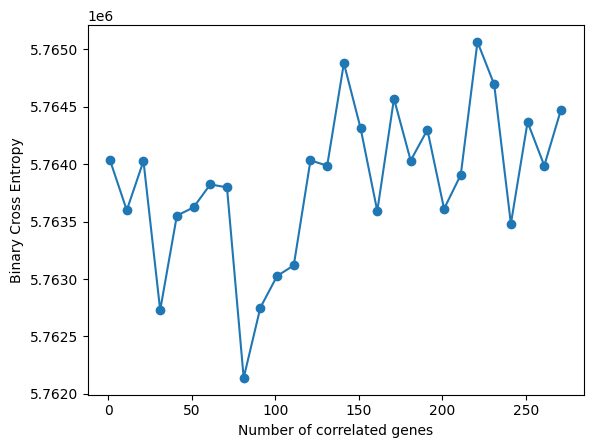

In [22]:
plt.plot(num_genes,  BCEs, "-o")
plt.xlabel("Number of correlated genes")
plt.ylabel("Binary Cross Entropy")

In [19]:
filtered_df = corr_matrix.loc[list(highly_correlated), list(highly_correlated)]

### Compute and compare the correlation between genes after reconstruction 

In [24]:
# reconstruct the input dataframe with VAE
def VAE_reconstruct_df(df, model):
    reconstruct_tensor = model.forward(torch.tensor(df.values, dtype=torch.float32))[0]
    dataframe = pd.DataFrame(reconstruct_tensor.detach().numpy(), columns=df.columns)

    return dataframe

In [26]:
noisy_inputs.keys()

dict_keys([1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271])

### Look at the correlation matrix of reconstructed genes for input genes which are highly correlated

In [31]:
VAE_reconstruct_df(noisy_inputs[1], model)[list(highly_correlated)].corr()

,CD3G,ZIC1,CYorf15A,ORM1,SLC17A3,CDC6,LGALS7,MCM10,CTAGE4,MAGEA3,...,DUOX1,TROAP,FCGR2B,NPR3,CKMT1B,ORC1L,IPW,OR2A7,TMEM176A,CDCA5
CD3G,1.000000,-0.393118,0.046713,0.139408,0.082030,0.292751,0.154672,0.273663,0.341381,0.106546,...,0.157942,0.257129,0.767462,0.267683,-0.143960,0.356682,-0.281305,0.371958,0.271571,0.178688
ZIC1,-0.393118,1.000000,-0.132089,-0.105769,-0.153877,0.088840,-0.042896,0.256507,-0.649840,0.203276,...,-0.278051,0.202553,-0.197812,-0.403004,-0.130398,0.142083,0.161296,-0.617991,0.016404,0.310667
CYorf15A,0.046713,-0.132089,1.000000,0.051334,0.066859,-0.160897,-0.011818,-0.151510,-0.128999,0.127428,...,-0.050576,-0.091551,-0.054362,0.051614,-0.008680,-0.049961,0.130015,-0.092648,0.005808,-0.092738
ORM1,0.139408,-0.105769,0.051334,1.000000,0.125654,-0.019813,-0.026105,-0.101611,0.323934,0.089079,...,0.094795,-0.044898,0.173686,0.144375,-0.144418,-0.073585,-0.177118,0.270903,0.295323,-0.082355
SLC17A3,0.082030,-0.153877,0.066859,0.125654,1.000000,-0.247891,-0.281142,-0.339504,0.159598,-0.145407,...,-0.394420,-0.349474,0.099708,0.546188,-0.431397,-0.266157,0.083288,0.055691,0.648730,-0.393188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ORC1L,0.356682,0.142083,-0.049961,-0.073585,-0.266157,0.928441,0.438352,0.956243,0.115521,0.554263,...,0.001624,0.956006,0.203488,-0.304594,0.072519,1.000000,-0.670816,0.133838,-0.010377,0.931739
IPW,-0.281305,0.161296,0.130015,-0.177118,0.083288,-0.683115,-0.405517,-0.632358,-0.327127,-0.370677,...,0.051420,-0.636795,-0.179475,0.199643,-0.185330,-0.670816,1.000000,-0.323892,-0.200872,-0.659098
OR2A7,0.371958,-0.617991,-0.092648,0.270903,0.055691,0.222203,0.428360,0.058599,0.943072,0.140475,...,0.454762,0.099962,0.287943,0.347223,0.418839,0.133838,-0.323892,1.000000,0.132803,0.006271
TMEM176A,0.271571,0.016404,0.005808,0.295323,0.648730,-0.009108,-0.232335,-0.068159,0.165566,-0.010590,...,-0.430269,-0.049740,0.385541,0.163917,-0.200833,-0.010377,-0.200872,0.132803,1.000000,-0.066390


In [37]:
diff_corr_1 = rnaseq_df[list(highly_correlated)].corr()- VAE_reconstruct_df(noisy_inputs[1], model)[list(highly_correlated)].corr()
diff_corr_101 = rnaseq_df[list(highly_correlated)].corr()- VAE_reconstruct_df(noisy_inputs[101], model)[list(highly_correlated)].corr()
diff_corr_201 = rnaseq_df[list(highly_correlated)].corr()- VAE_reconstruct_df(noisy_inputs[201], model)[list(highly_correlated)].corr()
diff_corr_271 = rnaseq_df[list(highly_correlated)].corr()- VAE_reconstruct_df(noisy_inputs[271], model)[list(highly_correlated)].corr()

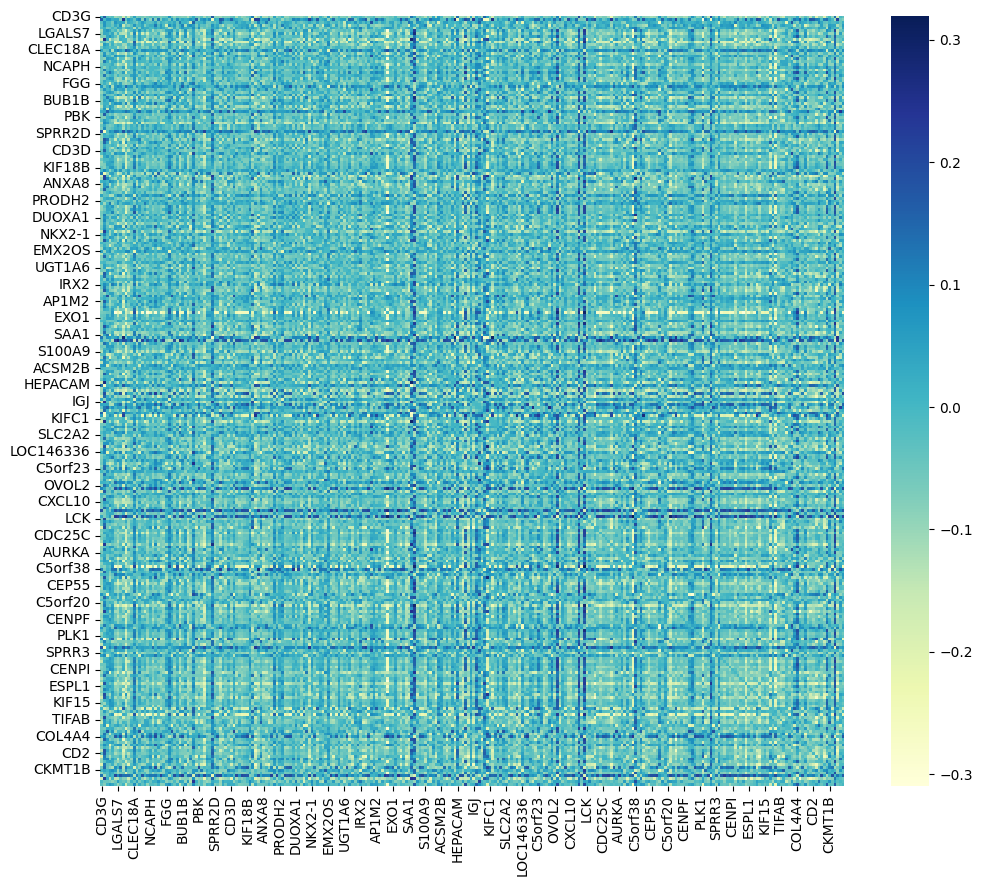

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_1, cmap='YlGnBu')

# Display the plot
plt.show()


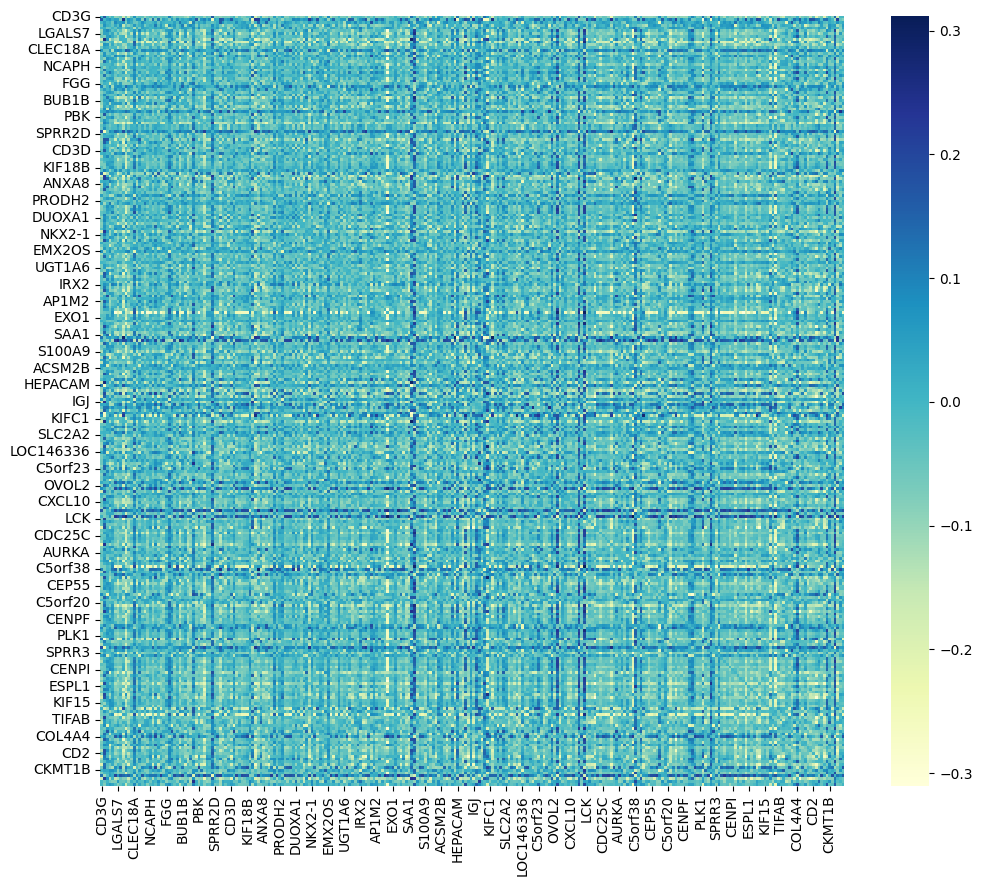

In [40]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_101, cmap='YlGnBu')

# Display the plot
plt.show()


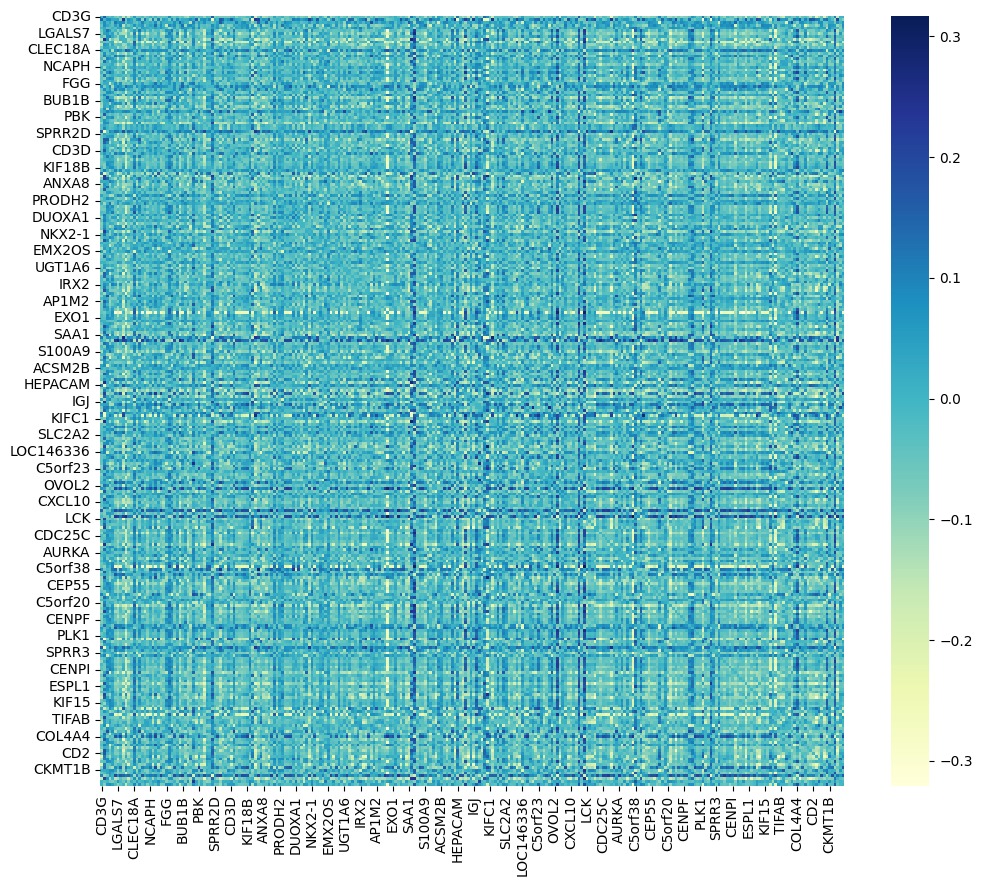

In [41]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_201, cmap='YlGnBu')

# Display the plot
plt.show()

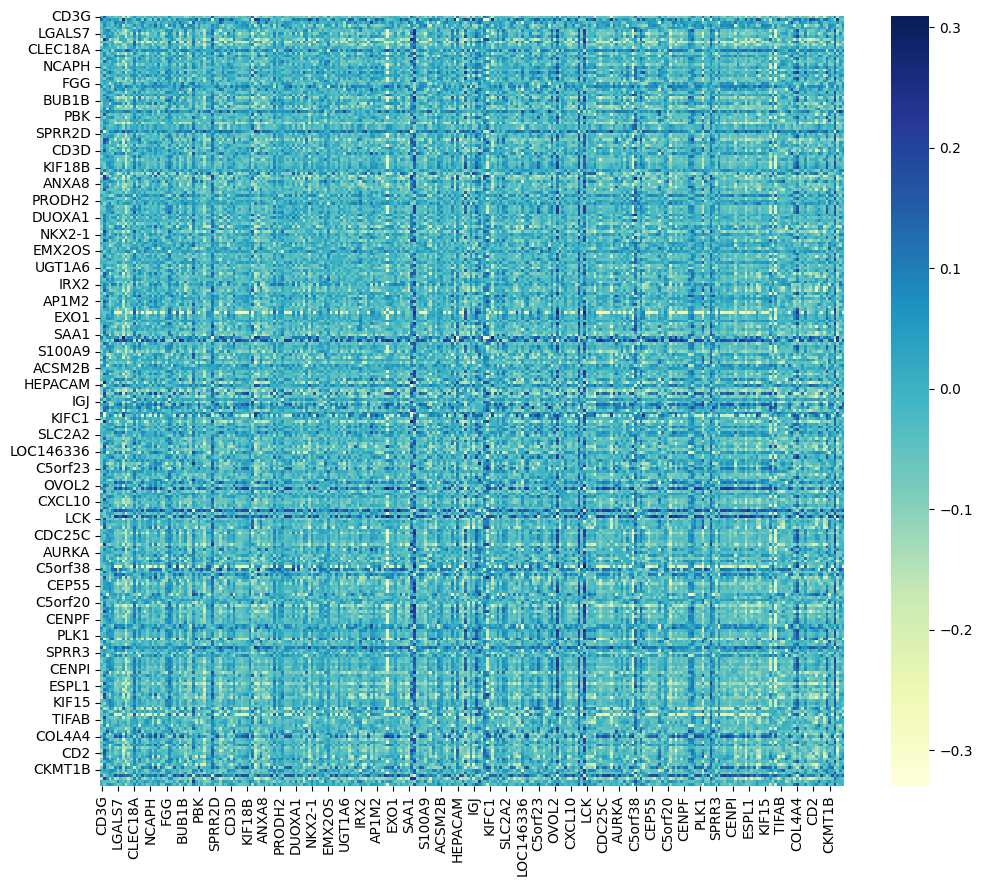

In [42]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_271, cmap='YlGnBu')

# Display the plot
plt.show()

### Perform downstream classification tasks when noise is added to highly correlated genes

In [43]:
# How well does the model reconstruct the input RNAseq data
def VAE_latent_out(df):
    mu = model.forward(torch.tensor(df.values, dtype=torch.float32))[2]
    sigma = model.forward(torch.tensor(df.values, dtype=torch.float32))[3]

    column_names = [str(i) for i in range(100)]

    mu = pd.DataFrame(mu.detach().numpy(), columns=column_names)
    sigma = pd.DataFrame(sigma.detach().numpy(), columns=column_names)

    return mu, sigma

In [44]:
latent_mu, latent_sigma = VAE_latent_out(rnaseq_df)

In [45]:
import pandas as pd
import umap.umap_ as umap

# Assuming you have a pandas DataFrame named 'latent_mu' with the data

# Extract the features from the DataFrame
features = latent_mu.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result = umap.UMAP().fit_transform(features)

# Create a new DataFrame with UMAP coordinates
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df = pd.concat([latent_mu, umap_df], axis=1)

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/umap/distances.py:108

In [46]:
embedded_dataframe = result_df.copy()

In [47]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
df = pd.read_table(tcga_tybalt_file_location)
# df.drop(columns=df.columns[0], axis=1, inplace=True)

In [48]:
embedded_dataframe["id"] = df["Unnamed: 0"]

In [49]:
# clinical data
clincal_file = "../../VAE_prject_data/raw/clinical_data.tsv"
clincal_df = pd.read_table(clincal_file)

In [50]:
clincal_df["id"] = clincal_df.portion_id.str[: embedded_dataframe["id"].str.len().min()]

In [51]:
merged_latent_clinical_df = pd.merge(
    clincal_df, embedded_dataframe, on="id", how="inner"
)

In [54]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

# Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df.copy()
merged_l_df = merged_l_df.dropna()

merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

X = merged_l_df[["UMAP1", "UMAP2"]]
y = merged_l_df["acronym"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Compute roc_auc_score
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

# Compute F1-score
f1 = f1_score(y_test, y_pred, average="macro")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute classification report
classification_metrics = classification_report(y_test, y_pred)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_metrics)

AUC-ROC: 0.33160256410256406
F1-score: 0.13672629545645418
Accuracy: 0.3684210526315789
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.33      0.33        24
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.39      0.67      0.49        30
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00         4

    accuracy                           0.37        76
   macro avg       0.12      0.17      0.14        76
weighted avg       0.26      0.37      0.30        76



/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F